In [1]:
import chainer

In [2]:
chainer.print_runtime_info()

Platform: Linux-4.19.76-linuxkit-x86_64-with-debian-bullseye-sid
Chainer: 7.7.0
ChainerX: Not Available
NumPy: 1.17.2
CuPy: Not Available
iDeep: Not Available


In [3]:
from sklearn.datasets import load_iris

# Iris データセットの読み込み
x, t = load_iris(return_X_y=True)

print('x:', x.shape)
print('t:', t.shape)

x: (150, 4)
t: (150,)


In [4]:
# それぞれデータ型を変換
x = x.astype('float32')
t = t.astype('int32')

In [5]:
# データセットを分割するモジュールの読み込み
#訓練データと検証データの二つを合わせたものとテストデータが7:3になるように分割
from sklearn.model_selection import train_test_split

x_train_val, x_test, t_train_val, t_test = train_test_split(x, t, test_size=0.3, random_state=0)

In [7]:
#訓練データと検証データを7:3に分割
x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=0)

In [8]:
import chainer.links as L
import chainer.functions as F

In [9]:
l = L.Linear(3, 2)

In [10]:
from chainer import Sequential

n_input = 4
n_hidden = 10
n_output = 3

net = Sequential(L.Linear(n_input, n_hidden), F.relu,
                 L.Linear(n_hidden, n_hidden), F.relu,
                 L.Linear(n_hidden, n_output))

In [11]:
optimizer = chainer.optimizers.SGD(lr=0.01)

In [12]:
optimizer.setup(net)

In [13]:
n_epoch = 30
n_batchsize = 16

In [14]:
import numpy as np

In [15]:
iteration = 0

results_train = {
    'loss': [],
    'accuracy': []
}

results_valid = {
    'loss' : [],
    'accuracy' : []
}

In [17]:
for epoch in range(n_epoch):

    # データセット並べ替えた順番を取得
    order = np.random.permutation(range(len(x_train)))

    # 各バッチ毎の目的関数の出力と分類精度の保存用
    loss_list = []
    accuracy_list = []

    for i in range(0, len(order), n_batchsize):
        # バッチを準備
        index = order[i:i+n_batchsize]
        x_train_batch = x_train[index,:]
        t_train_batch = t_train[index]

        # 予測値を出力
        y_train_batch = net(x_train_batch)

        # 目的関数を適用し、分類精度を計算
        loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)

        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)

        # 勾配のリセットと勾配の計算
        net.cleargrads()
        loss_train_batch.backward()

        # パラメータの更新
        optimizer.update()

        # カウントアップ
        iteration += 1

    # 訓練データに対する目的関数の出力と分類精度を集計
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)

    # 1エポック終えたら、検証データで評価
    # 検証データで予測値を出力
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y_val = net(x_val)

    # 目的関数を適用し、分類精度を計算
    loss_val = F.softmax_cross_entropy(y_val, t_val)
    accuracy_val = F.accuracy(y_val, t_val)

    # 結果の表示
    print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(
        epoch, iteration, loss_train, loss_val.array))

    # ログを保存
    results_train['loss'] .append(loss_train)
    results_train['accuracy'] .append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)

epoch: 0, iteration: 5, loss (train): 1.1707, loss (valid): 1.1216
epoch: 1, iteration: 10, loss (train): 1.0912, loss (valid): 1.0457
epoch: 2, iteration: 15, loss (train): 1.0433, loss (valid): 1.0922
epoch: 3, iteration: 20, loss (train): 0.9724, loss (valid): 1.0092
epoch: 4, iteration: 25, loss (train): 0.9451, loss (valid): 0.9835
epoch: 5, iteration: 30, loss (train): 0.9376, loss (valid): 0.9571
epoch: 6, iteration: 35, loss (train): 0.9124, loss (valid): 0.9220
epoch: 7, iteration: 40, loss (train): 0.8884, loss (valid): 0.9017
epoch: 8, iteration: 45, loss (train): 0.8470, loss (valid): 0.9699
epoch: 9, iteration: 50, loss (train): 0.8010, loss (valid): 0.9826
epoch: 10, iteration: 55, loss (train): 0.8833, loss (valid): 0.8337
epoch: 11, iteration: 60, loss (train): 0.7936, loss (valid): 0.7485
epoch: 12, iteration: 65, loss (train): 0.7655, loss (valid): 0.7363
epoch: 13, iteration: 70, loss (train): 0.7350, loss (valid): 0.7184
epoch: 14, iteration: 75, loss (train): 0.734

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0, 0.5, 'Output of Objective functions')

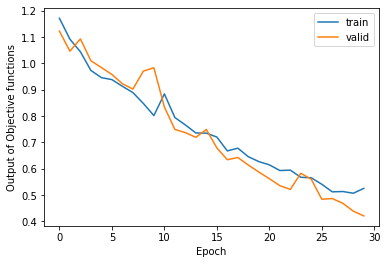

In [20]:
plt.plot(results_train['loss'], label='train')
plt.plot(results_valid['loss'], label='valid')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Output of Objective functions')

Text(0, 0.5, 'Accuracy')

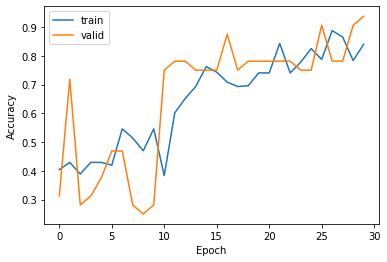

In [22]:
plt.plot(results_train['accuracy'], label='train')
plt.plot(results_valid['accuracy'], label='valid')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')